<a href="https://colab.research.google.com/github/lauramaria99/SenalesEEG/blob/main/Proyecto2_Grupo9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Programa de Bioingeniería** 

**Bioseñales y Sistemas** 

**Proyecto 2**

**Estudiantes:** 

Isabella Ariza Cuberos C.C 1152470641 - Maria Camila Parra Córdoba C.C 1233191182 - Laura María Muñoz Bravo C.C 1216729952.



In [ ]:
#Se importan las librerias basicas
import numpy as np;
import matplotlib.pyplot as plt;
import scipy.io as sio;
from astropy.stats import median_absolute_deviation
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") #Se ignoran las alertas para mejorar la visualización.

**Rutina 1**

In [ ]:
#Definición de la función que perimte aplicar el algoritmo de Mallat para un nivel de descomposicón y un tipo de Wevelet definido.
def mallat(senal, nivel,tipo):
  #Se cargan los datos para el Wevelet con Daubechies.
  senales_multiresolucion = sio.loadmat('senales_wavelet_scala_db6.mat')
  #Se eliminan las entradas unidimensionales de la matriz de datos "senal".
  senal = np.squeeze(senal)
  #Se elige el tipo de Wevlet para realizar la descomposición ya sea con Haar o Daubechies
  if tipo=='haar':
    #Se define wavelet y escala para Haar
    wavelet = [-1/np.sqrt(2) , 1/np.sqrt(2)];
    scale = [1/np.sqrt(2) , 1/np.sqrt(2)];

  elif tipo=='db6':
    #Se define wavelet y escala para Daubechies
    wavelet = np.squeeze(senales_multiresolucion['wavelet']);
    scale = np.squeeze(senales_multiresolucion['escala']);
    #Señal wavelet y escala invertida
    wavelet_inv = np.squeeze(senales_multiresolucion['wavelet_inv']);
    scale_inv = np.squeeze(senales_multiresolucion['escala_inv']);
  else:
    tipo=int(input('Opción incorrecta. Elija 1 o 2: '))
  detalle=[]
  senal_descomponer = senal;
  #Se descompone la señal obteniendo la aproximación y los detalles para un nivel dado.
  for i in range(1,nivel+1):
    if (senal_descomponer.shape[0] % 2) != 0:
      senal_descomponer = np.append(senal_descomponer, 0);
    #Se descompone la señal en aproximación y detalles usando la convolución entre la señal y la escala y el Wevelet respectivamente. (Definidos anteriormente)
    aprox = np.convolve(senal_descomponer,scale,'full');
    #a partir del primero toma cada dos
    aprox = aprox[1::2]; 
    Detail = np.convolve(senal_descomponer,wavelet,'full');
    #A partir del primero toma cada dos
    Detail = Detail[1::2];
    detalle.append(Detail)
    senal_descomponer=aprox;
    #La función retorna la última aproximación de la señal y una lista con los detalles obtenidos.
  return senal_descomponer, detalle

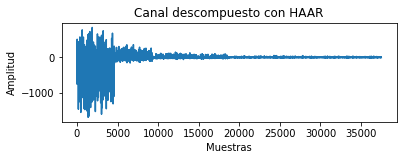

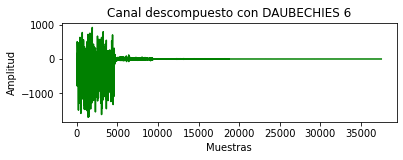

In [ ]:
#Ejemplo rutina 1
mat_contents = sio.loadmat('eeg_eog.mat') #Se cargan los datos de la señal eeg.
senal=mat_contents['data'] #Se obtienen los datos para relizar la descomposición
senal=senal[0,:] #Se elige el canal deseado.
aprox, detalle=mallat(senal,3,'haar')
aprx, detall=mallat(senal,3,'db6')
#Se concatenan la apoximación y los detalles obtenidos para cada tipo de Wevelet obteniendo una señal descompuesta para cada tipo.
conc=np.concatenate((aprox,detalle[2],detalle[1],detalle[0]))
conc1=np.concatenate((aprx,detall[2],detall[1],detall[0]))
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(conc)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Canal descompuesto con HAAR')
plt.show()
plt.subplot(2,1,1);
plt.plot(conc1,'g')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Canal descompuesto con DAUBECHIES 6')
figura.subplots_adjust(hspace=0.5)
plt.show()

**Rutina 2**

In [ ]:
#Se define la rutina que permite dividir una señal por épocas dada una frecuencia de muestreo y el tiempo de cada época
def epoca(senal, Fs,t):
  puntos=senal.shape[0] #Se obtiene la forma de la señal en la posición inicial.
  tiempo=puntos/Fs #Se obtiene el tiempo según los puntos y la frecuencia de muestreo especificada.
  a=tiempo/t #Se obtiene las muestras según la duración de la época
  a=round(a)
  b=0
  w=0
  sen=[]
  time=[]
  #Se define un ciclo reocrriendo un rango hasta el número de muestras.
  for h in range(0,a):
    tiempo=np.arange(b,b+t,1/Fs) #Se crea un vector de tiempo, desde el tiempo inmediatamente anterior, hasta la duración de la epoca.
    b=b+t
    s=senal[int(w):int(w+(t*Fs))] #Puntos de la nueva señal en epocas
    w=int(w+(t*Fs))#Número de muestras

    sen.append(s)#Se agrega a una lista la amplitud de la señal por épocas
    time.append(tiempo)#Se agrega a una lista el tiempo de la señal por epocas
  return (sen,time)

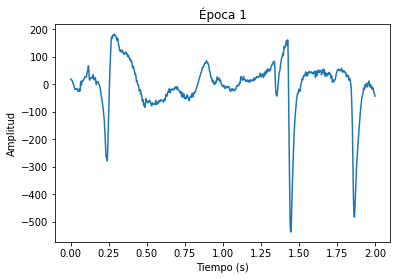

In [ ]:
#Ejemplo Rutina 2
s, tim=epoca(senal,1000,2)
#Se grafica la señal por epocas.
plt.plot(tim[0][:len(s[0])],s[0])
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Época 1')
plt.show()

**Rutina 3**

In [ ]:
#Se define la función que permite detectar cuáles epocas son atípicas en la señal, definiendo un umbral
def detectar(senal,des):
  ep=[]
  um=[]
  for i in range(0,len(senal)):
    n=senal[i].shape[0]
    umbral= np.mean(senal[i])+(des*(np.std(senal[i]))) #Se define el umbral deseado por arriba de la señal
    umbraln=np.mean(senal[i])-(des*(np.std(senal[i])))#Se define el umbral deseado por abajo de la señal
    um.append(umbral)
#Según el rango de la señal, se agrega la posición de la muestra atípica a una lista vacía
    if umbral<max(senal[i]) or umbraln>min(senal[i]):
      ep.append(i+1)
#Se muestra cuáles son las épocas atípicas
  if ep==[]:
    print('No hay épocas atípicas') 
  else:
    print('Las épocas atípicas son: ', ep)
  return um,ep

Las épocas atípicas son:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


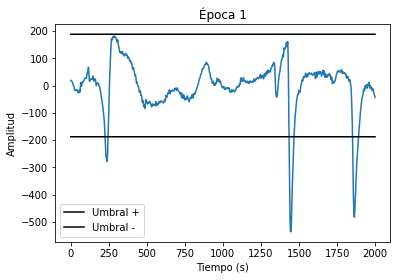

In [ ]:
f,ep=detectar(s,2)
print(ep)
n=s[0].shape[0]
plt.plot(s[0]) #Se grafica la señal a la cual se le definirá si tiene épocas atípicas
plt.plot(np.ones(n)*f[0],'k',label='Umbral +') #Se grafica el umbral de la señal
plt.plot(-1*np.ones(n)*f[0],'k',label='Umbral -')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Época 1')
plt.legend()
plt.show();

**Rutina 4**

In [ ]:
#Se define la rutina para calcular el nivel de ruido 'median absolute deviation' (MAD)
def ruido(aprox,det):
  stdc = np.zeros((len(det),1));
  for p in range(0,len(det)):
    stdc[p]=(np.median(np.absolute(det[p])))/0.6745; #Nivel de ruido
  return stdc

In [ ]:
print('Con Haar:')
stdc1=ruido(aprox,detalle) #Nivel de ruido a cada detalle de la señal con Haar
print('Nivel de ruido detalle 1:',stdc1[0])
print('Nivel de ruido detalle 2:',stdc1[1])
print('Nivel de ruido detalle 3:',stdc1[2])
print('')
print('Con DB6:')
stdc2=ruido(aprx,detall) #Nivel de ruido a cada detalle de la señal con Daubechies.
print('Nivel de ruido detalle 1:',stdc2[0])
print('Nivel de ruido detalle 2:',stdc2[1])
print('Nivel de ruido detalle 3:',stdc2[2])


Con Haar:
Nivel de ruido detalle 1: [1.81327855]
Nivel de ruido detalle 2: [4.85808864]
Nivel de ruido detalle 3: [10.51468171]

Con DB6:
Nivel de ruido detalle 1: [0.10672168]
Nivel de ruido detalle 2: [2.4414481]
Nivel de ruido detalle 3: [7.91548423]


**Rutina 5**

In [ ]:
#Rutina de limpieza Wavelet 
def limpieza(a,d,stdc,tipo,umbral,ponderacion):
  '''
  tipo= 'hard' ó 'Soft' 
  umbral= 'universal' , 'minimax' ó 'sure '
  ponderacion = 'global', 'primer nivel' ó 'por nivel '
  '''
  Detalle=[]
  #Umbral
  n=a.shape[0]
  Detalle=[]
  #Esta función permite elegir entre el tipo de aplicación del umbral que se desea obtener, el tipo de estimación y de ponderación
  if umbral=='universal':
    j=0
    for i in range(0,len(d)): 
      n1=d[i].shape[0]    
      j=j+n1
    n=n+j
    thr = np.sqrt(2*(np.log(n))) #Umbral tipo universal
  elif umbral=='minimax':
    j=0
    for i in range(0,len(d)):
       n1=d[i].shape[0]
       j=j+n1
    n=n+j
    thr=0.3936+(0.1829*(np.log(n)/np.log(2))) #Umbral minimax

  elif umbral=='sure': #condición del tipo de umbral elegido
    deta=[] #Se crea lista vacia para guarda informacion
    for k in range(0,len(d)): #Ciclo para concatenar los detalles 
      deta.extend(d[k])
    nv=np.sqrt(np.sort(np.absolute(deta)))# Se construye el vector nv
    rk=[] #Lista vacia para guarda los indices de riesgo
    j=0
    for i in range(0,len(d)):#Ciclo para determinar el valor de n
       n2=d[i].shape[0]
       j=j+n2
    h=j
    for i in range(0,len(nv)):
      r=((h-(2*i))+(np.sum(nv[:i])+(h-i)*nv[h-k])/h) #Se calculan los valores del riesgo
      rk.append(r)
    p=np.where(rk==np.min(rk))#Se toma el minimo valor de riesgo
    thr=nv[p] #Se obtiene el valor del umbral SURE
    
  #Según tipo de aplicación de umbralización
  if tipo=='hard':

    #Segun la ponderación
    if ponderacion=='global':#Global
      stdc=1
      for v in range(0,len(d)):
        det=[]
        for j in range(0,len(d[v])):
          if np.abs(d[v][j])< thr*stdc: 
            de=0
            det.append(de)
          else:
            de=d[v][j]
            det.append(de)

        Detalle.append(det)

    elif ponderacion=='primer nivel': #Primer nivel
      stdc=stdc[0]
      for v in range(0,len(d)):
        det=[]
        for j in range(0,len(d[v])):
          if np.abs(d[v][j])< thr*stdc:
            de=0
            det.append(de)
          else:
            de=d[v][j]
            det.append(de)

        Detalle.append(det)
  
    elif ponderacion=='por nivel': #Por nivel
      stdc=stdc
      for v in range(0,len(d)):
        det=[]
        for j in range(0,len(d[v])):
          if np.abs(d[v][j])< thr*stdc[v]:
            de=0
            det.append(de)
          else:
            de=d[v][j]
            det.append(de)

        Detalle.append(det)
      
      
  elif tipo=='soft':
    #Segun la ponderación
    if ponderacion=='global':#Global
      stdc=1
      for v in range(0,len(d)):
        det=[]
        for j in range(0,len(d[v])):
          if np.abs(d[v][j])< thr*stdc:
            de=0
            det.append(de)
          else:
            de=((d[v][j])/(np.abs(d[v][j])))*(np.abs(d[v][j])-thr*stdc)
            det.append(de)

        Detalle.append(det)

    elif ponderacion=='primer nivel': #Primer nivel
      stdc=stdc[0]
      for v in range(0,len(d)):
        det=[]
        for j in range(0,len(d[v])):
          if np.abs(d[v][j])< thr*stdc:
            de=0
            det.append(de)
          else:
            de=((d[v][j])/(np.abs(d[v][j])))*(np.abs(d[v][j])-thr*stdc)
            de=de[0]
            det.append(de)

        Detalle.append(det)
  
    elif ponderacion=='por nivel': #Por nivel
      stdc=stdc
      for v in range(0,len(d)):
        det=[]
        for j in range(0,len(d[v])):
          if np.abs(d[v][j])< thr*stdc[v]:
            de=0
            det.append(de)
          else:
            de=((d[v][j])/(np.abs(d[v][j])))*(np.abs(d[v][j])-thr*stdc)
            de=de[0]
            det.append(de)

        Detalle.append(det)

     
  return a,Detalle,thr,stdc

Con Haar


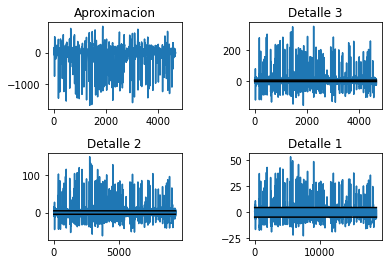

4.589580128567235
Con DB6


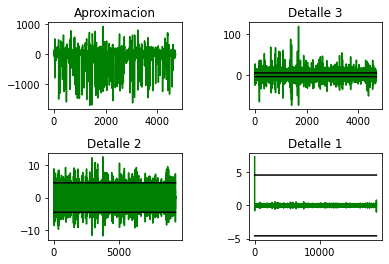

In [ ]:
#Se prueba la rutina 5 con el Wavelet para Haar y posteriormente para Daubechies. Graficando la aproximacimación y los detalles de las señales según se haya definido el tipo de aplicación, estimación y ponderación
#Para Haar
print('Con Haar')
aproxi,detallee,thr1,stdc1=limpieza(aprox,detalle,stdc1,'hard','universal','global')
n1=len(detalle[0])
n2=len(detalle[1])
n3=len(detalle[2])

figura=plt.figure()
plt.subplot(2,2,1)
plt.plot(aprox)
plt.title("Aproximacion")
plt.subplot(2,2,2)
plt.plot(detalle[2])
plt.plot(np.ones(n3)*thr1*stdc1,'k');
plt.plot(-1*np.ones(n3)*thr1*stdc1,'k');
plt.title("Detalle 3")
plt.subplot(2,2,3)
plt.plot(detalle[1])
plt.plot(np.ones(n2)*thr1*stdc1,'k');
plt.plot(-1*np.ones(n2)*thr1*stdc1,'k');
plt.title("Detalle 2")
plt.subplot(2,2,4)
plt.plot(detalle[0])
plt.plot(np.ones(n1)*thr1*stdc1,'k');
plt.plot(-1*np.ones(n1)*thr1*stdc1,'k');
plt.title("Detalle 1")
figura.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show();
print(thr1)

#Para DB6
print('Con DB6')
aprox1,detalle1,thr2,stdc2=limpieza(aprx,detall,stdc2,'hard','universal','global')
n_1=len(detall[0])
n_2=len(detall[1])
n_3=len(detall[2])

figura=plt.figure()
plt.subplot(2,2,1)
plt.plot(aprx,'g')
plt.title("Aproximacion")
plt.subplot(2,2,2)
plt.plot(detall[2],'g')
plt.plot(np.ones(n_3)*thr2*stdc2,'k');
plt.plot(-1*np.ones(n_3)*thr2*stdc2,'k');
plt.title("Detalle 3")
plt.subplot(2,2,3)
plt.plot(detall[1],'g')
plt.plot(np.ones(n_2)*thr2*stdc2,'k');
plt.plot(-1*np.ones(n_2)*thr2*stdc2,'k');
plt.title("Detalle 2")
plt.subplot(2,2,4)
plt.plot(detall[0],'g')
plt.plot(np.ones(n_1)*thr2*stdc2,'k');
plt.plot(-1*np.ones(n_1)*thr2*stdc2,'k');
plt.title("Detalle 1")
figura.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show();



**Rutina 6**



*   **Reconstrucción de la señal**




In [ ]:
#Se define una señal que reconstruye la señal.
def reconstruccion(a,d,original,tipo):
  '''
  tipo= 'haar' ó 'db6'
  '''

  if tipo=='haar':
    #Señal wavelet y escala invertida HAAR
    wavelet_inv = [1/np.sqrt(2) , -1/np.sqrt(2)];
    scale_inv = [1/np.sqrt(2) , 1/np.sqrt(2)]
  elif tipo=='db6':
    senales_multiresolucion = sio.loadmat('senales_wavelet_scala_db6.mat')
    #Señal wavelet y escala invertida DB6
    wavelet_inv = np.squeeze(senales_multiresolucion['wavelet_inv']);
    scale_inv = np.squeeze(senales_multiresolucion['escala_inv']);

  d=list(reversed(d)) #Se invierten los detalles
  de=np.array(d)

  for i in range(0,len(de)):
    
    if a.shape[0] > len(de[i]):
      a = a[0:len(de[i])];

    else:
      a=a

    n = a.shape[0];
    a_inv = np.zeros((2*n));
    a_inv[0::2] = a;
    a_inv[1::2] = 0;
    A = np.convolve(a_inv,scale_inv,'full'); #Convolución entre la aproximación invertida y la escala invertida.

    nd = len(de[i]);
    d_inv = np.zeros((2*nd));
    d_inv[0::2] = de[i];
    d_inv[1::2] = 0;

    D = np.convolve(d_inv,wavelet_inv,'full');#Convolución entre el detalle invertido y el Wavelet invertido.

    a = A + D; #Se suman las convoluciones

  if tipo=='db6':
    ds = np.where(a == a.min())[0]-np.where(original == original.min())[0]
    a=a[ds[0]:] 

  SIGNAL=a[0:len(original)]



  return SIGNAL

9377
9377
18751
18751
37501
37501
9405
9405
18777
18777
37521
37521
Reconstrucción con Haar


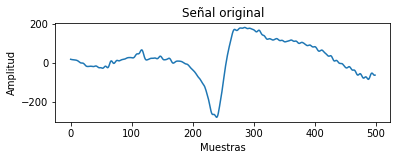

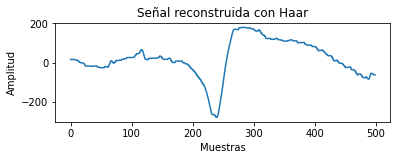

Reconstrucción con DB6


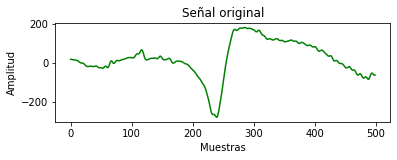

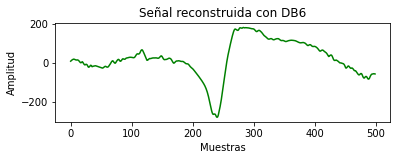

In [ ]:
#Se prueba la función, y se grafica la señal original y la reconstruida
SIGNAL=reconstruccion(aproxi,detallee,senal,'haar')
SIGNAL2=reconstruccion(aprox1,detalle1,senal,'db6')
print('Reconstrucción con Haar')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal[0:500])
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.show()
plt.subplot(2,1,2)
plt.plot(SIGNAL[0:500])
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal reconstruida con Haar")
figura.subplots_adjust(hspace=0.5)
plt.show()

print('Reconstrucción con DB6')
figu=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal[0:500],'g')
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.show()
plt.subplot(2,1,2)
plt.plot(SIGNAL2[0:500],'g')
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal reconstruida con DB6")
figura.subplots_adjust(hspace=0.5)
plt.show()




*   **Comparación de la señal**




In [ ]:
#Se define una función que permite comparar la señal original con la señal filtrada
def comparacion(rec,original):
  fil=original[0:len(rec)]-rec #Se eiminan los picos más grandes, dando como resultado picos muy pequeños. Este es el resultado de la filtración
  figura=plt.figure()
  plt.subplot(2,1,1);
  plt.plot(original[0:500])
  plt.xlabel("Muestras")
  plt.ylabel("Amplitud")
  plt.title("Señal original")
  plt.show()
  plt.subplot(2,1,2)
  plt.plot(fil[0:500])
  plt.xlabel("Muestras")
  plt.ylabel("Amplitud")
  plt.title("Señal filtrada")
  figura.subplots_adjust(hspace=0.5)
  plt.show()

  return fil


Señal filtrada con Haar


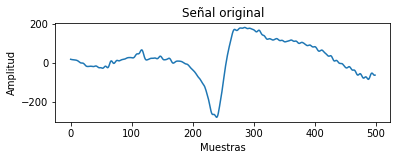

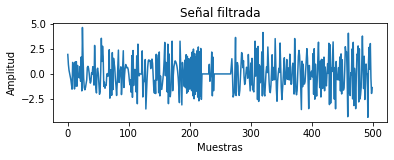

Señal filtrada con DB6


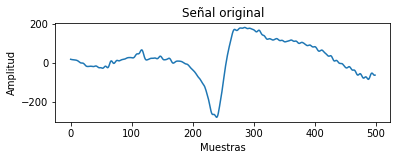

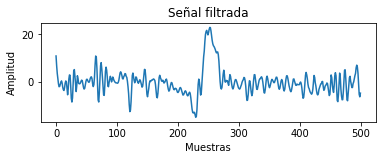

In [ ]:
#Ejemplo rutina 7
print('Señal filtrada con Haar')
c=comparacion(SIGNAL,senal)
print('Señal filtrada con DB6')
c1=comparacion(SIGNAL2,senal)

### **Análisis de reducción de ruido en señales EEG**


A continuación se implementan las diferentes rutinas necesarias para creación de una librería que permite aplicar la técnica de Wavelet Denoising sobre señales EEG.

La siguiente librería permite dividir una señal continua en épocas, detectar épocas atípicas según un umbral determinado y posteriormente aplicar el algoritmo de Mallat, aplicar la limpieza Wavelet y reconstruir la señal obteniendo al final una señal filtrada, para posteriormente realizar una comparación entre la señal original y la filtrada, evaluando las diferentes combinaciones de parámetros recibidos por la librería. 



Con el fin de iniciar el proceso de filtrado por medio de la tecnica Wavelet Denoising, es necesario dividir la señal en una cantidad épocas especificas, las cuales para este caso de estudio estaran conformadas por segmentos de 2 segundos de la señal de entrada, que corresponde al canal 0 de la señal EEG, el cual a simple vista presenta un nivel de ruido significativo debido a que es la señal entregada por uno de los electrodos ubicados en la zona frontal de la cabeza del paciente en cuestión. Este canal, se encuentra contaminado principalmente por el ruido causado por el paradeo. Ahora bien, una vez dividida la señal en épocas se establece un umbral para cada una de ellas definido como la media o promedio de la señal más o menos 2 desviaciones estandar, lo anterior con el fin de solo realizar el filtrado a las épocas que realmente presentan datos atípicos evitando así la eliminación de datos significativos. Una vez realizado este proceso se procede a implementar la descomposición, umbralización y reconstrucción de la señal. Finalmente por efectos del tipo de señal que se tiene 'EEG' y puesto que la técnica Wavelet Denoising elimina las amplitudes más pequeñas de la señal a filtrar, se debe aplicar un paso más para obtener la señal realmente filtrada, restando la señal original de la filtrada por esta técnica, se obtendrá la señal 'EEG' libre de artefactos por parpadeo.

A continuación se presentan las diferentes combinaciones de parámetros representativos de esta técnica, obteniendo los siguiemtes resultados. 

**Variación de los parámetros**

**Método:** HAAR



In [ ]:
#Rutina 2
#Se divide en épocas de 2 segundos la señal del canal cero
mat_contents = sio.loadmat('eeg_eog.mat')
senal=mat_contents['data']
senal=senal[0,:]
s, tim=epoca(senal,1000,2)

#Rutina 3
#Se detecta cuáles épocas son atípicas en el canal anterior.
det=detectar(s,2)

Las épocas atípicas son:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Una vez aplicado el umbral definido a las épocas de la señal, se encuentra que todas las épocas son atipicas, por lo tanto se procede a aplicarle la tecnica de filtrado a cada una de ellas, como se muestra a continuación.
En este caso se hará uso de la transformada Haar como tipo de Wavelet definido para el filtrado. Realizando la variación de parametros se obtiene lo siguiente:


*   **Aplicación del umbral:** Hard
*   **Umbral:** universal

*   **Ponderación:** global



In [ ]:
import librosa
import librosa.display
y, sr = librosa.load('/content/101_1b1_Al_sc_Meditron.wav')
aprox, detalle=mallat(y,3,'haar') #Se aplica el algoritmo de mallat a cada una de las épocas, con tres niveles de descomposición

#Rutina 4
stdc=ruido(aprox,detalle) #Se estima el nivel de ruido

#Rutina 5
aproxi,detallee,thr,stdc1=limpieza(aprox,detalle,stdc,'hard','universal','por nivel')#Limpieza Wavelet

#Rutina 6
rec=reconstruccion(aproxi,detallee,y,'haar')#Reconstrucción

#Rutina 7
fil=y-rec #Filtración
l=[]
for i in range(0,3):
  a="{:.8f}".format(rec[i])
  l.append(a)
l=np.asanyarray(l)

uu=y[0:len(rec)]-rec
print(uu[30])
librosa.output.write_wav('result1.wav',uu,sr)


0.0003684060648084242


[187.81471829420408, 235.9978238197531, 181.99631728680362, 250.07749514680302, 174.74233552799788, 307.96236340060557, 225.72711403736648, 263.37473630129267, 201.5646142854009, 207.60150093264258, 231.27720914326133, 172.57376156834601, 245.15889597614762, 160.54873573577672, 219.53665765403596, 144.5586909583533, 165.6339322299493, 209.88421662151444, 136.828243707687]
[[ 1.59446444]
 [ 4.36651232]
 [10.50046059]]
188



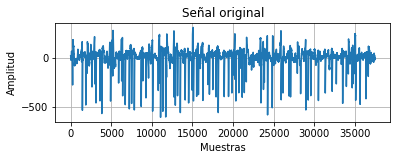

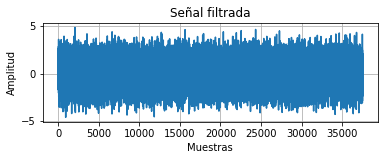

La estimación del nivel de ruido es:  1.369818087694003


In [ ]:
f=[]
#Se realiza el procedimiento de limpieza a cada una de las épocas de la señal con el canal definido.
print(det)
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar') #Se aplica el algoritmo de mallat a cada una de las épocas, con tres niveles de descomposición

  #Rutina 4
  stdc=ruido(aprox,detalle) #Se estima el nivel de ruido

  #Rutina 5
  aproxi,detallee,thr,stdc1=limpieza(aprox,detalle,stdc,'hard','universal','global')#Limpieza Wavelet

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')#Reconstrucción

  #Rutina 7
  fil=s[i][0:len(rec)]-rec #Filtración
  f.extend(fil)
print(stdc)
print('')
#Se grafican la señal original y la filtrada
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()
#Nivel de ruido de la señal filtrada
MAD=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD)


*   **Aplicación del umbral:** Hard
*   **Umbral:** universal

*   **Ponderación:** primer nivel

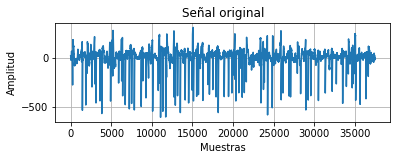

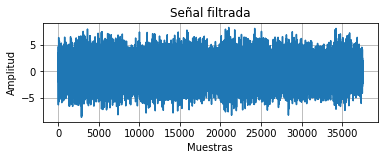

La estimación del nivel de ruido es:  2.204140412023614


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','universal','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD1=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD1)


*   **Aplicación del umbral:** Hard
*   **Umbral:** universal

*   **Ponderación:** por nivel

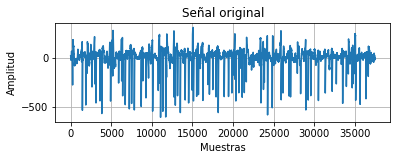

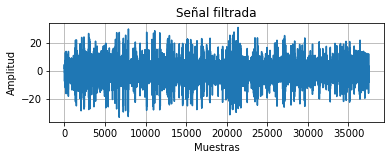

La estimación del nivel de ruido es:  3.4513859068021646


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','universal','por nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD2=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD2)

*   **Aplicación del umbral:** Hard
*   **Umbral:** minimax

*   **Ponderación:** global

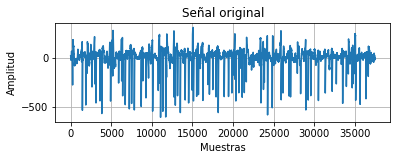

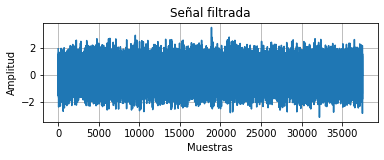

La estimación del nivel de ruido es:  0.7967335610486753


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','minimax','global')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD3=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD3)

*   **Aplicación del umbral:** Hard
*   **Umbral:** minimax

*   **Ponderación:** primer nivel

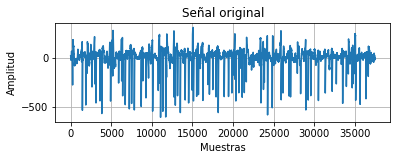

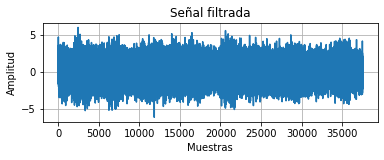

La estimación del nivel de ruido es:  1.4926562579652478


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','minimax','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD4=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD4)


*   **Aplicación del umbral:** Hard
*   **Umbral:** minimax

*   **Ponderación:** por nivel

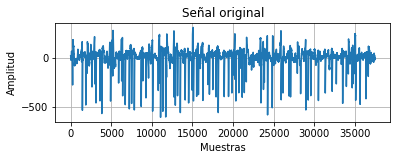

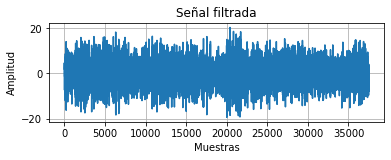

La estimación del nivel de ruido es:  3.032605841500467


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','minimax','por nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD5=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD5)

In [ ]:
#Función para el Dataframe
def displaydf(dataframe, cols = None, rows = None):
    with pd.option_context("display.max_columns", cols):
        with pd.option_context("display.max_rows", rows):
            display(dataframe)
    return True

In [ ]:
#Dataframe con el nivel de ruido de todas las combinaciones para identificar cuál es la mejor filtración.
ru = pd.DataFrame({'MAD1':pd.Series(MAD),'MAD2':pd.Series(MAD1),'MAD3':pd.Series(MAD2),'MAD4':pd.Series(MAD3),'MAD5':pd.Series(MAD4),'MAD6':pd.Series(MAD5)})
ru = displaydf(ru)
print(ru)
 

,MAD1,MAD2,MAD3,MAD4,MAD5,MAD6
0,1.369818,2.20414,3.451386,0.796734,1.492656,3.032606


True


De acuerdo a los resultados obtenidos realizando variaciones en los parámetros recibidos por la librería dejando fijo el tipo de Wavelet utilizado y el tipo de aplicación de umbralización, se obtuvo que las mejores combinaciones de parámetros corresponden a usar el tipo de ponderación global independientemente del tipo de estimación del umbral. Sin embargo, se considera que al hacer uso de la ponderización global, es decir que a  todos los detalles de todos los niveles se les aplica el valor del umbral sin ponderar, se elimina más de la infromación que se espera, debido a que al umbral no esta ponderizado respecto a los detalles y datos que realmente no son atipicos, son filtrados. Por lo tanto se considera que es mejor opción realizar la ponderación de **primer nivel**, la cual tienen en cuenta el nivel de ruido de los coeficientes del detalle del primer nivel de descomposición, obteniendo así una señal con un escalamiento y filtrado más preciso. Posteriormente, al considerar los efectos del tipo de ponderación de primer nivel es notorio que el nivel de ruido es menor aplicando la estimación **minimax** en conjunto con la ponderación ya definida. 

Así mismo a continuación se realizan las combinaciones de parametros, dejando fijo el tipo de Wavelet utilizado y el tipo de aplicación de umbralización, para este caso Soft, obteniendo lo siguiente:

*   **Aplicación del umbral:** Soft
*   **Umbral:** universal

*   **Ponderación:** primer nivel

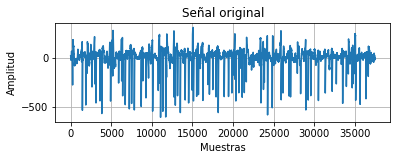

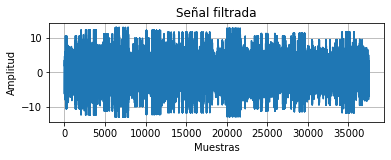

La estimación del nivel de ruido es:  3.2977098459064726


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'soft','universal','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD11=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD11)

*   **Aplicación del umbral:** soft
*   **Umbral:** minimax

*   **Ponderación:** primer nivel

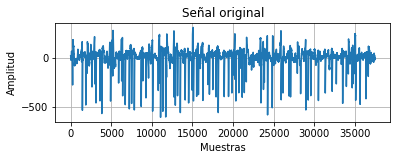

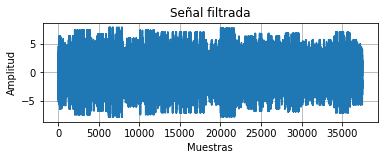

La estimación del nivel de ruido es:  2.691682269280033


In [ ]:
#Se replica el procedimiento anterior con diferentes parámetros
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'soft','minimax','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
print('')
figura=plt.figure()
plt.subplot(2,1,1);
plt.plot(senal)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal original")
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(f)
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.title("Señal filtrada")
figura.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

MAD12=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD12)

In [ ]:
ruidos = pd.DataFrame({'MAD11':pd.Series(MAD11),'MAD12':pd.Series(MAD12)})
ruidos = displaydf(ruidos)
print(ruidos)

,MAD11,MAD12
0,3.29771,2.691682


True


Al considerar variaciones en el tipo de aplicación de umbral, soft o hard, es posible afirmar que resulta menos eficiente usar **soft**, puesto que, al realizar la estimación del nivel de ruido los resultados son mucho mayores en comparación a los obtenidos mediante la aplicación hard, haciendo uso de los mismos parametros para el tipo de umbral y el tipo de ponderización, por lo tanto usando la aplicación de umbral hard se obtiene una señal con un mejor proceso de filtrdo.

Finalmente, la mejor combinación de parámetros cuando el tipo de Wavelet utilizado es el correspondiente a la transformada HAAR, será: 

*   **Aplicación del umbral:** hard
*   **Umbral:** minimax
*   **Ponderación:** primer nivel


Por otro lado, se tiene otro tipo de Wavelet y es el referente a Daubechies 6, el cual también permite realizar el proceso de descomposición, umbralización y reconstrucción de la señal. Sin embargo al realizar la definición de las rutinas que realizan estas funciones, se encontró que en el proceso de reconstrucción de la señal se generaba un desplazamiento en la señal filtrada, lo que dificulta el análalisis de la señal de interés EEG, puesto que para realizar el correcto filtrado de la señal se deben restar la señal original con la señal reconstruida y al tener este desfase, la señal procesada presentará más ruido del esperado, siendo ineficiente el método. 
Para solucionar el problema expuesto, se eliminó el desfase entre las señales y posteriormente estas se restaron, sin embargo al eliminar este desfase se eliminan datos de la señal, aproximadamente unos 70 datos. Es por esto que implementar la técnica Wavelet Denoising para cada una de las épocas no sería eficiente, pues se perdería una gran cantidad de datos y el ruido de la señal final aumentaría,por lo tanto, el analisis de los mejores la mejor combinación de parámetros se hará a partir de los resultados obtenidos mediante la aplicación de la transformada Haar.


Finalmente se tiene que de acuerdo a los resultados obtenidos, no es posible determinar que tipo de Wavelete es más efectivo, o el efecto que presenta sobre la señal. Sin embargo los resultados obtenidos mediante la transformada Haar, dan cuenta de que es posible comprimir una señal y conservar en la mitad de los datos aproximadamente la misma cantidad de energía, conservando la mayor cantidad de información pertinente posible, lo que significa que este metodo de compresión de información como lo define la teória es eficiente. 

Asi mismo, se obtuvo que la mejor combinación de parametros cuando se usa el método Haar, es la aplicación del umbral hard, estimación del umbral por el metodo minimax y el tipo de ponderación de primer nivel.


Ahora bien, se presentará el efecto que presenta el filtrado de las señales al variar el tamaño de las épocas. En este caso se hará uso de las mejores combinaciones de parámetros encontrados, para evaluar este comportamiento.

Se tomaran tres ejemplos, uno para epocas de 3 segundos, uno para epocas de 6s y otro para epocas de 10 s.

Épocas de 3s

In [ ]:
#Rutina 2
mat_contents = sio.loadmat('eeg_eog.mat')
senal=mat_contents['data']
senal=senal[0,:]
s, tim=epoca(senal,1000,3)
f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','minimax','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)

MAD0=(np.median(np.absolute(f)))/0.6745
print("La estimación del nivel de ruido es: ", MAD0)

La estimación del nivel de ruido es:  1.5691852765447187


Épocas de 6s

In [ ]:
#rutina 2
s, tim=epoca(senal,1000,6)

f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','minimax','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
MAD01=(np.median(np.absolute(fil)))/0.6745
print("La estimación del nivel de ruido es: ", MAD01)

La estimación del nivel de ruido es:  1.5952685575675958


Épocas de 10s

In [ ]:
#rutina 2
s, tim=epoca(senal,1000,10)

f=[]
for i in range(0,len(s)):
  #Rutina 1
  aprox, detalle=mallat(s[i],3,'haar')

  #Rutina 4
  stdc=ruido(aprox,detalle)

  #Rutina 5
  aproxi,detallee,thr,stdc=limpieza(aprox,detalle,stdc,'hard','minimax','primer nivel')

  #Rutina 6
  rec=reconstruccion(aproxi,detallee,s[i],'haar')

  #Rutina 7
  fil=s[i][0:len(rec)]-rec
  f.extend(fil)
MAD02=(np.median(np.absolute(fil)))/0.6745
print("La estimación del nivel de ruido es: ", MAD02)

La estimación del nivel de ruido es:  1.612801874839616


In [ ]:
ro = pd.DataFrame({'MAD1':pd.Series(MAD0),'MAD2':pd.Series(MAD01),'MAD3':pd.Series(MAD02)})
ro = displaydf(ro)
print(ro)

,MAD1,MAD2,MAD3
0,1.569185,1.595269,1.612802


True


A partir de los resultados obtenidos se observa, que a medida que aumenta la duración de las epocas y con esto su tamaño, el nivel de ruido de la señal aumenta. Esto se debe a que cuando las épocas son más pequeñas se realiza un mejor filtrado de la señal, pues se hace una mejor discriminación de datos atipicos y con esto una mayor eliminación del ruido de la señal. Lo anterior sustenta el hecho de que se debe dividir la señal por épocas antes de aplicar la técnica de Wavelet Denoising , pues esto permitirá identificar cuales son las epocas que realmente poseen ruido y así realizar un buen filtrado, evitando la eliminación de datos representativos de la señal.

**Conclusiones**



*   El proceso de eliminación de ruido haciendo uso de la transformada de Wavelet resulta un procedimiento muy util debido a que en la obtención de señales EEG, se tiene como resultado un cierto número de canales generando un gran volumen de datos, de los cuales algunos están alterados por diferentes factores externos. Es por eso, que se utiliza el método de Wavelet Denoising el cual es un método que realiza una transformación de la señal comparando un umbral. Los valores absolutos de la señal transformada que sean menores al umbral definido, se vuelven cero y se conservan los demás.
*   A partir del procedimiento realizado en el presente trabajo, fue posible realizar una limpieza de la señal EEG, pero es necesario, para un futuro trabajo, definir un umbral más específico, que permita determinar a partir de la división por épocas de la señal, definir cuáles son las épocas que presentan ruido significativo sin eliminar datos que son clinicamente importantes.
*   Para obtener resultados válidos en el proyecto, fue necesario la variación de los distintos parámetros para la definición del umbral analizando cual combinación obtuvo mejor resultado con un nivel de ruido menor en la señal filtrada, se obtuvo como resultado final, que el tipo de ponderación adecuado es la ponderación de "primer nivel" con estimación "minimax" y tipo de aplicación "hard". Además, se considera que la división por épocas de la señal es influyente para una mejor filtración de ella.




In [2]:
!git clone https://github.com/lauramaria99/SenalesEEG.git

fatal: destination path 'SenalesEEG' already exists and is not an empty directory.
